## 1. Environment Setup

### 1.1. Library Installation & Imports

In [1]:
!pip install opendatasets tensorflow -q

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import opendatasets as od
from keras import layers, models, Input
from sklearn.metrics import classification_report, confusion_matrix

### 1.2. Downloading Dataset

In [3]:
od.download('https://www.kaggle.com/datasets/markdaniellampa/fish-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Klikolio
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/markdaniellampa/fish-dataset


100%|██████████| 1.58G/1.58G [00:20<00:00, 81.6MB/s]


### 1.3. Configuration & Hyperparameters

We define our constants in one place. This makes it easy to experiment with different image sizes or batch sizes later.

In [4]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
BASE_DIR = 'fish-dataset/FishImgDataset'

train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')

## 2. Data Loading

To avoid PyDataset warnings and optimize performance, we use image_dataset_from_directory. This creates a tf.data.Dataset object which is much faster and more memory-efficient than the older ImageDataGenerator.

In [5]:
# Load training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Load validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Load test data (shuffle=False is crucial for evaluation metrics)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds.class_names
print(f"Detected Classes: {class_names}")

Found 8809 files belonging to 31 classes.
Found 2751 files belonging to 31 classes.
Found 1761 files belonging to 31 classes.
Detected Classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


## 3. Data Augmentation & Normalization

We define an augmentation pipeline as part of the model layers. This creates synthetic variations of the images (flips, rotations) to prevent overfitting. We also add a Rescaling layer to normalize pixel values from $[0, 255]$ to $[0, 1]$.

In [6]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

rescale_layer = layers.Rescaling(1./255)

## 4. Modelling

### 4.1. CNN Architecture

In [7]:
num_classes = len(class_names)

model = models.Sequential([
    # Explicit Input Layer to avoid warnings
    Input(shape=(150, 150, 3)),

    # Preprocessing Layers
    data_augmentation,
    rescale_layer,

    # Feature Extraction (Convolutional Blocks)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Classification Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5), # Regularization
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,049,567 (72.67 MB)

 Trainable params: 19,049,567 (72.67 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2. Model Training

We use EarlyStopping to monitor the validation loss. If the model stops improving, it will stop training and revert to the best-performing weights.

In [9]:
# Stop training if validation loss doesn't improve for 5 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop]
)

Epoch 1/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 38s 138ms/step - accuracy: 0.2429 - loss: 2.7611 - val_accuracy: 0.3428 - val_loss: 2.3291
Epoch 2/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.3189 - loss: 2.4197 - val_accuracy: 0.3933 - val_loss: 2.1143
Epoch 3/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.3710 - loss: 2.2147 - val_accuracy: 0.4398 - val_loss: 1.9461
Epoch 4/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - accuracy: 0.4083 - loss: 2.0650 - val_accuracy: 0.5162 - val_loss: 1.6342
Epoch 5/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step - accuracy: 0.4384 - loss: 1.9670 - val_accuracy: 0.5340 - val_loss: 1.5519
Epoch 6/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.4757 - loss: 1.8081 - val_accuracy: 0.5852 - val_loss: 1.4215
Epoch 7/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - accuracy: 0.5071 - loss: 1.6909 - val_accuracy: 0.5947 - val_loss: 1.3565
Epoch 8/25
276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.5228 - loss: 1

## 5. Transfer Learning

For comparison, we implement a second model using Transfer Learning. We use MobileNetV2 with pre-trained weights from ImageNet. We freeze the base model so that we only train our custom classification layers at the top.

In [10]:
# Load pre-trained base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # Freeze weights

transfer_model = models.Sequential([
    Input(shape=(150, 150, 3)),
    rescale_layer,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Transfer Learning Model compiled successfully.")

/tmp/ipython-input-3754200328.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Transfer Learning Model compiled successfully.


## 6. Evaluation and Performance Visualization

We visualize the training history and evaluate the model using a Classification Report to see the Precision, Recall, and F1-score for each fish species.

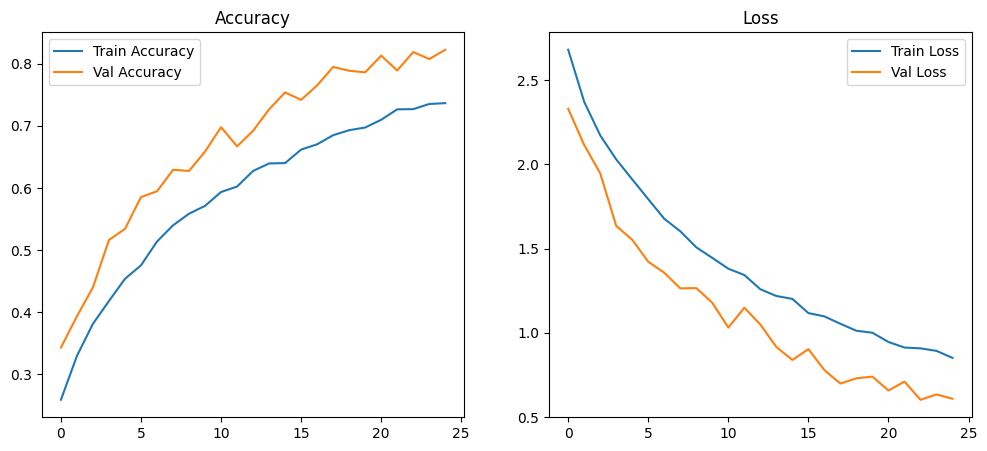

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.7830 - loss: 0.7836
Final Test Accuracy: 80.75%


In [11]:
# Plot Learning Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Final Evaluation on Test Set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

In [12]:
# Comprehensive Classification Report
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print('Detailed Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))

56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step
Detailed Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.59      0.56      0.58        34
        Big Head Carp       0.91      0.67      0.77        43
   Black Spotted Barb       0.74      0.85      0.79        40
              Catfish       0.88      0.68      0.76        62
       Climbing Perch       0.75      0.40      0.52        30
 Fourfinger Threadfin       0.88      0.79      0.83        38
       Freshwater Eel       0.81      0.69      0.75        55
       Glass Perchlet       0.96      0.88      0.92        77
                 Goby       0.77      0.86      0.81       124
            Gold Fish       1.00      0.93      0.96        41
              Gourami       0.88      0.90      0.89        63
           Grass Carp       0.88      0.97      0.92       238
 Green Spotted Puffer       0.95      0.86      0.90        22
          Indian Carp       0.85      0.96   